In [85]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Natural language processing
import nltk

# Regular expressions
import re

# Textblob for sentiment analysis
from textblob import TextBlob

# Bert for sentiment analysis
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Vader for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# OpenAI's GPT model
import openai

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Word cloud generation
from wordcloud import WordCloud

# NLTK stopwords and date/time handling
from nltk.corpus import stopwords
from datetime import datetime as dt

# Custom module for fetching market news
from fetch_news import MarketNews

# yfinance for price retrieval
import yfinance as yf

# Random number generation
import random

# Visual parameters
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [2]:
# Download the vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# If you need help with the MarketNews class
MarketNews?

Init signature: MarketNews(api_key)
Docstring:     
Fetches market news for a given stock ticker and index.

Attributes:
    url (str): URL endpoint for news API.
    query (dict): Parameters for API request.
    articles (list): List of fetched articles.
    data (DataFrame): Processed articles in DataFrame format.
    _api_key (str): API key for accessing the news API.
Init docstring: Initializes MarketNews with an API key.
File:           c:\users\aungs_tko91wk\eigen\wip[sentimentanalysis]\fetch_news\news.py
Type:           type
Subclasses:     

In [4]:
ticker = "DIS"
# index = "NYSE"
# api_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxx"
# base_url = "https://api.markets.sh/api/v1/symbols"

# start = "2022-09-17"
# end = "2023-09-17"

# news = MarketNews(api_key=api_key)

# news.get_news(
#     index,
#     ticker,
#     base_url=base_url,
#     start=start,
#     end=end,
#     limit=10000
# )

In [5]:
headlines = pd.read_csv(f"data/{ticker}_headlines.csv", index_col=0, parse_dates=True)
news_start = headlines.index.min()
news_end = headlines.index.max()

print(f"News start date: {news_start}")
print(f"News end date: {news_end}")
print(f"News timeframe: {(news_end - news_start).days} days")

News start date: 2022-10-06 16:25:00
News end date: 2023-09-14 22:25:20
News timeframe: 343 days


In [6]:
headlines = headlines.dropna()
headlines.head()

,DIS
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...


In [7]:
stop_words = stopwords.words("english")

def process_text(text, lower_case, remove_stopwords, stop_words, regex_pattern="[^a-zA-Z\s]"):
    """
    Cleans and processes a given text.

    Parameters:
    - text (str): The text to be processed.
    - lower_case (bool): Whether to convert the text to lower case.
    - remove_stopwords (bool): Whether to remove stop words.
    - stop_words (list): A list of stop words to remove.
    - regex_pattern (str): A regex pattern to remove unwanted characters. Defaults to "^[a-zA-Z\s]".

    Returns:
    - str: The processed text.
    
    The function performs the following operations in sequence:
    1. Removes retweets, mentions, and hyperlinks.
    2. Optionally converts text to lower case.
    3. Removes unwanted characters based on regex pattern.
    4. Optionally removes stop words.
    5. Joins the words back into a string and returns it.
    """
    
    # Remove retweets, mentions, and links
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r'https//[A-Za-z0-9./]+','', text)
    text = text.replace("\n", "")
    text = re.sub('@[\w]+', '', text)

    # Handle contractions
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

    # Convert to lower case if specified
    if lower_case:
        text = text.lower()

    # Remove characters based on regex pattern
    text = re.sub(regex_pattern, "", text)

    # Tokenize text
    word_list = text.split()
    word_list = [w for w in word_list if len(w) > 1]

    # Remove stop words if specified
    return " ".join([word for word in word_list if word not in stop_words]) if remove_stopwords \
        else " ".join(word_list)

In [8]:
headlines["processed_text"] = headlines[ticker].apply(
    process_text, lower_case=True, remove_stopwords=True, stop_words=stop_words
)

headlines.head()

,DIS,processed_text
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...


In [9]:
# indiv_word_series = headlines["processed_text"].str.split().explode()
# all_words = indiv_word_series.to_list()
# redundancies = ["disney", "disneys", "stock"]
# pruned_words = [w for w in all_words if w not in redundancies]
# text_data = " ".join(pruned_words)

# wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=88).generate(text_data)
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [10]:
# n_words = 5
# word_count = indiv_word_series.value_counts()
# top_words = word_count[~word_count.index.isin(redundancies)][:n_words]

In [11]:
# def tb_sentiment(text):
#     sentiment_analysis = TextBlob(text)
#     return sentiment_analysis.sentiment

# def tb_extract_scores(text, aspect):
#     if aspect == "polarity":
#         return tb_sentiment(text)[0]
#     elif aspect == "subjectivity":
#         return tb_sentiment(text)[1]

# def tb_extract_sentiment(polarity):
#     return "Positive" if polarity > 0 else "Negative" if polarity < 0 else "Neutral"

# headlines_textblob = headlines.copy()
# headlines_textblob["textblob_polarity"] = headlines_textblob["processed_text"].apply(tb_extract_scores, aspect="polarity")
# headlines_textblob["textblob_subjectivity"] = headlines_textblob["processed_text"].apply(tb_extract_scores, aspect="subjectivity")
# headlines_textblob["textblob_sentiment"] = headlines_textblob["textblob_polarity"].apply(tb_extract_sentiment)

headlines_textblob = pd.read_csv("data/textblob_sentiment.csv", index_col=0, parse_dates=True)

In [12]:
headlines_textblob.head()

,DIS,processed_text,textblob_polarity,textblob_subjectivity,textblob_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,0.000000,0.000000,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,0.000000,0.000000,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,0.000000,0.000000,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,0.175325,0.441558,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,0.000000,1.000000,Neutral


In [13]:
# def bert_preprocess(text, tokenizer):
#     tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**tokens)
#     return int(torch.argmax(outputs.logits)) + 1

# def bert_sentiment(logit):
#     return "Positive" if logit > 3 else "Negative" if logit < 3 else "Neutral"

# def bert_extract_sentiment(text, tokenizer):
#     logit = bert_preprocess(text, tokenizer)
#     return bert_sentiment(logit)

# tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# headlines_bert = headlines.copy()
# headlines_bert["bert_sentiment"] = headlines_bert[ticker].apply(bert_extract_sentiment, tokenizer=tokenizer)

headlines_bert = pd.read_csv("data/bert_sentiment.csv", index_col=0, parse_dates=True)

In [14]:
headlines_bert.head()

,DIS,processed_text,bert_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,Positive
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,Positive
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,Negative


In [15]:
# vader = SentimentIntensityAnalyzer()

# def vader_extract_scores(text, vader):
#     return vader.polarity_scores(text)

# def vader_get_score(text, vader, score):
#     return vader_extract_scores(text, vader)[score]

# def vader_extract_sentiment(text, vader):
#     score = vader_get_score(text, vader, score="compound")
#     return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

# headlines_vader = headlines.copy()
# headlines_vader["vader_neu"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="neu")
# headlines_vader["vader_pos"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="pos")
# headlines_vader["vader_neg"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="neg")
# headlines_vader["vader_compound"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="compound")
# headlines_vader["vader_sentiment"] = headlines_vader["processed_text"].apply(vader_extract_sentiment, vader=vader)

headlines_vader = pd.read_csv("data/vader_sentiment.csv", index_col=0, parse_dates=True)
headlines_vader.head()

,DIS,processed_text,vader_neu,vader_pos,vader_neg,vader_compound,vader_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,0.472,0.528,0.0,0.6808,Positive


In [16]:
# tb_sentiment = headlines_textblob["textblob_sentiment"]
# bert_sentiment = headlines_bert["bert_sentiment"]
# vader_sentiment = headlines_vader["vader_sentiment"]

# sentiments = pd.concat([tb_sentiment, bert_sentiment, vader_sentiment], axis=1)
# sentiment_analysis = pd.concat([headlines, sentiments], axis=1)

# sentiment_analysis

In [17]:
def gpt_sentiment(headline, api_key, model="gpt-3.5-turbo-16k"):
    """
    Function to ask a question to ChatGPT.
    
    Parameters:
    - question (str): The question to ask.
    - model (str): The model to use, default is "gpt-3.5-turbo-16k".
    
    Returns:
    - str: The answer from ChatGPT
    """
    
    openai.api_key = api_key
    
    messages = [
        {"role": "system", "content": \
         "You are a helpful assistant who will be performing sentiment analysis. \
         Your task is to respond with 'Positive', 'Negative', or 'Neutral', and nothing else."},
        {"role": "user", "content": f"What is the sentiment of the following headline: {headline}"}
    ]

    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
    )
    
    # Extract the assistant's reply
    answer = response['choices'][0]['message']['content']
    return answer

# OPENAI_API_KEY = "xxxxxxxxxxxxxxxxxxxxxxxx"

In [18]:
# sentiment_analysis["chatgpt_sentiment"] = sentiment_analysis[ticker].apply(gpt_sentiment, api_key=OPENAI_API_KEY)

sentiment_analysis = pd.read_csv("data/sentiment_analysis.csv", index_col=0, parse_dates=True)
sentiment_analysis.head()

,DIS,processed_text,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,Neutral,Positive,Neutral,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,Neutral,Positive,Neutral,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,Neutral,Neutral,Neutral,Positive
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,Positive,Positive,Neutral,Neutral
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,Neutral,Negative,Positive,Positive


In [19]:
# Function to check if there are different sentiments from three models
def different_sentiments(row):
    return len(set([row["textblob_sentiment"], row["bert_sentiment"], row["vader_sentiment"]])) == 3

# Drop the "processed_text" column from the sentiment_analysis DataFrame
zoom_in = sentiment_analysis.drop("processed_text", axis=1)

# Filter rows where the chatgpt_sentiment is "Negative"
chatgpt_negative = zoom_in["chatgpt_sentiment"] == "Negative"

# Filter rows where the chatgpt_sentiment is "Neutral"
chatgpt_neutral = zoom_in["chatgpt_sentiment"] == "Neutral"

# Filter rows where the chatgpt_sentiment is "Positive"
chatgpt_positive = zoom_in["chatgpt_sentiment"] == "Positive"

# Apply the different_sentiments function to each row to check if there are differing sentiments from other models
disagreeing_other_models = zoom_in.apply(lambda row: different_sentiments(row), axis=1)

In [20]:
# Define the number of samples to select
n_samples = 3

# Filter rows where chatgpt_sentiment is "Neutral" and there is a disagreement with other models
comparison_1 = zoom_in[chatgpt_neutral & disagreeing_other_models]

# Randomly select 'n_samples' rows from the filtered data with a fixed random state for reproducibility
sample_1 = comparison_1.sample(n_samples, random_state=42)

sample_1

,DIS,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2023-05-11 14:41:18,Remote and hybrid work look set to continue ac...,Negative,Positive,Neutral,Neutral
2023-04-03 20:53:41,Disney-DeSantis war of words heats up at annua...,Neutral,Positive,Negative,Neutral
2022-11-25 16:52:42,Apple Buying Manchester United? More Like Chin...,Neutral,Negative,Positive,Neutral


In [21]:
# Inspect the article headlines in sample 1
sample_1[ticker].to_list()

['Remote and hybrid work look set to continue across Europe',
 'Disney-DeSantis war of words heats up at annual meeting',
 'Apple Buying Manchester United? More Like Chinese Art Marrying French Rap']

In [22]:
# Filter rows where chatgpt_sentiment is "Positive" and there is a disagreement with other models
comparison_2 = zoom_in[chatgpt_positive & disagreeing_other_models]

# Randomly select 'n_samples' rows from the filtered data with a fixed random state for reproducibility
sample_2 = comparison_2.sample(n_samples, random_state=42)

sample_2

,DIS,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2023-08-15 18:02:54,Linear TV viewing sinks below 50% as streaming...,Positive,Negative,Neutral,Positive
2023-06-24 05:21:51,Directors Guild of America votes to ratify new...,Positive,Negative,Neutral,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,Neutral,Negative,Positive,Positive


In [23]:
# Inspect the article headlines in sample 2
sample_2[ticker].to_list()

['Linear TV viewing sinks below 50% as streaming soars to new heights',
 'Directors Guild of America votes to ratify new contract with studios',
 'DraftKings Shares Gain 8% After Report of Possible ESPN Partnership']

In [24]:
# Filter rows where chatgpt_sentiment is "Negative" and there is a disagreement with other models
comparison_3 = zoom_in[chatgpt_negative & disagreeing_other_models]

# Randomly select 'n_samples' rows from the filtered data with a fixed random state for reproducibility
sample_3 = comparison_3.sample(n_samples, random_state=42)

sample_3

,DIS,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2023-03-30 18:23:39,ABC News lays off several senior executives am...,Neutral,Positive,Negative,Negative
2022-11-29 04:36:40,Hoping to beat the tourist crowd on your trip ...,Neutral,Negative,Positive,Negative
2023-04-05 00:08:55,How Disney and DeSantis started feuding,Neutral,Positive,Negative,Negative


In [25]:
# Inspect the article headlines in sample 3
sample_3[ticker].to_list()

['ABC News lays off several senior executives amid broader Disney cost-cutting in ‘shock’ to newsroom',
 'Hoping to beat the tourist crowd on your trip to Japan? That ship has sailed',
 'How Disney and DeSantis started feuding']

In [26]:
# Function to remove redundant words from a row of text
def remove_redundant_words(row, redundancies):
    row["processed_text"] = [w for w in row["processed_text"] if w not in redundancies]
    return row

# Function to concatenate lists of words into entire strings
def get_entire_strings(*texts):
    entire_strings = []
    for text in texts:
        entire_strings.append(" ".join(text.explode()))
    return tuple(entire_strings)

# Function to generate WordClouds from strings
def generate_wcs(*strings):
    wcs = []
    for string in strings:
        wc = WordCloud(
            background_color="white", 
            height=400, 
            width=800, 
            colormap="Dark2"
        )
        wcs.append(wc.generate(string))
    return tuple(wcs)

# Function to plot a WordCloud
def plot_wc(wc, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Copying relevant columns and renaming them
true_labels = sentiment_analysis[[ticker, "chatgpt_sentiment"]].copy()
true_labels.columns = [ticker, "sentiment"]

# Preprocessing text data
true_labels["processed_text"] = true_labels[ticker].apply(
    process_text, lower_case=True, remove_stopwords=True, stop_words=stop_words
)
true_labels["processed_text"] = true_labels["processed_text"].str.split()
true_labels = true_labels[[ticker, "processed_text", "sentiment"]]

# Separating data into positive, neutral, and negative sentiments
positive = true_labels["sentiment"] == "Positive"
neutral = true_labels["sentiment"] == "Neutral"
negative = true_labels["sentiment"] == "Negative"

# List of redundant words to remove
redundant_words = ["disney"]

# Applying the remove_redundant_words function to each sentiment group
true_labels_pos = true_labels[positive].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)
true_labels_neg = true_labels[negative].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)
true_labels_neu = true_labels[neutral].apply(
    remove_redundant_words, redundancies=redundant_words, axis=1
)

# Concatenating processed text into entire strings for each sentiment
pos_words, neu_words, neg_words = get_entire_strings(
    true_labels_pos["processed_text"], 
    true_labels_neu["processed_text"], 
    true_labels_neg["processed_text"]
)

# Generating WordClouds for each sentiment
pos_wc, neg_wc, neu_wc = generate_wcs(pos_words, neg_words, neu_words)

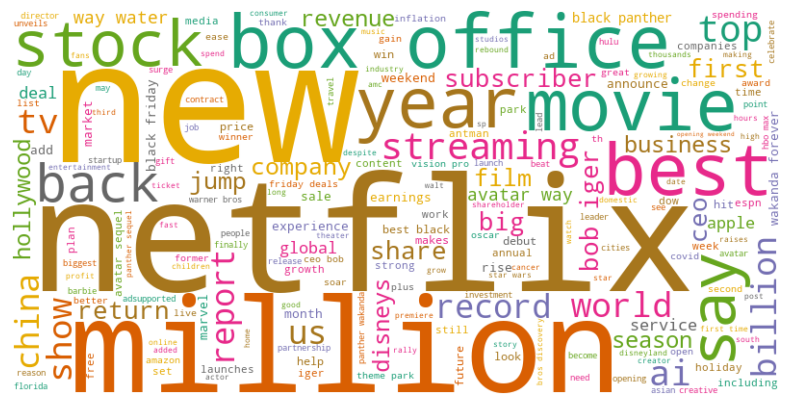

In [27]:
plot_wc(pos_wc)

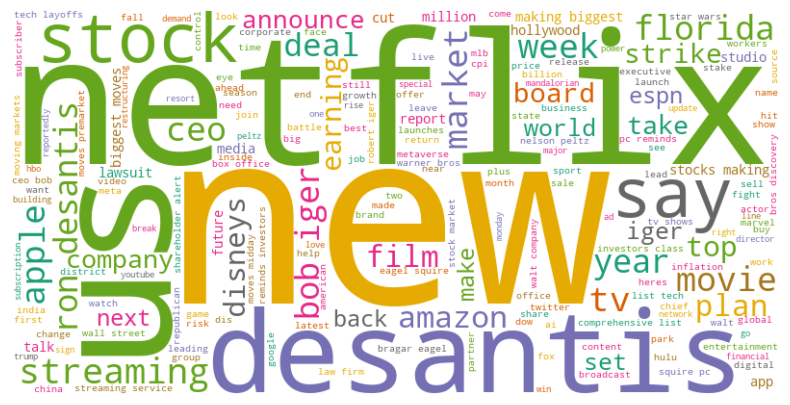

In [28]:
plot_wc(neu_wc)

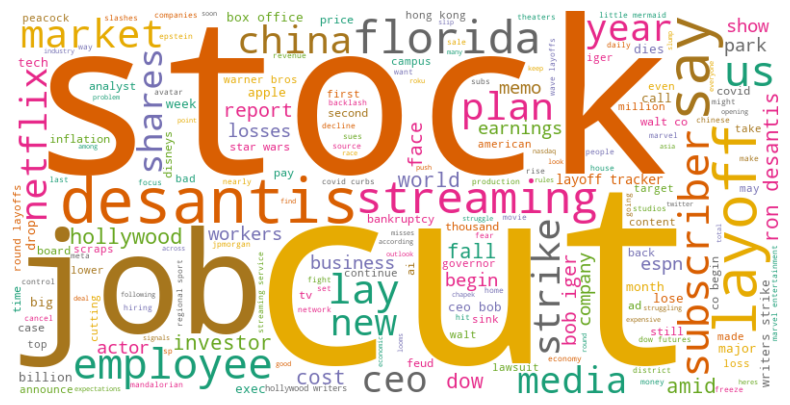

In [29]:
plot_wc(neg_wc)

In [30]:
# Map sentiment to integers
true_labels["sentiment_score"] = true_labels["sentiment"].map({
    "Neutral": 0, "Negative": -1, "Positive": 1
})

true_labels.head()

,DIS,processed_text,sentiment,sentiment_score
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,"[jakks, pacific, toy, company, mend, watch, up...",Neutral,0
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,"[disney, sanderson, sisters, lead, fourth, qua...",Neutral,0
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,"[jakks, pacific, relative, undervaluation, mak...",Positive,1
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,"[espn, nears, large, new, partnership, draftki...",Neutral,0
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,"[draftkings, shares, gain, report, possible, e...",Positive,1


[*********************100%%**********************]  1 of 1 completed


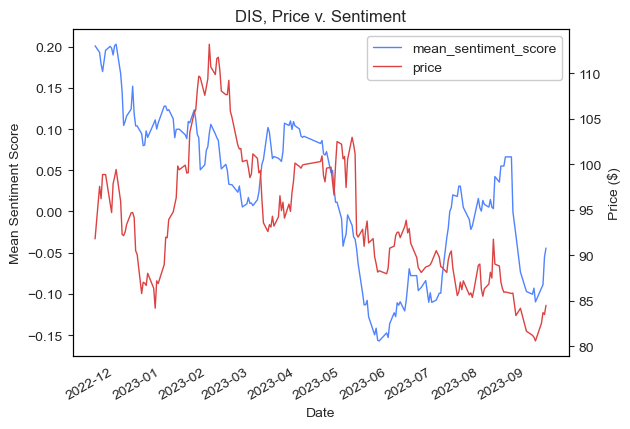

In [52]:
# Define start date and end date for price retrieval
stock_start = news_start
stock_end = news_end + pd.DateOffset(days=1)

# Store prices in dataframe
prices = pd.DataFrame(yf.download(ticker, stock_start, stock_end)["Adj Close"])
prices.columns = ["price"]

# Set the rolling window size
n_days = 30

# Calculate daily mean sentiment from true labels
daily_mean_sentiment = true_labels.groupby(true_labels.index.date)["sentiment_score"].mean()

# Copy original prices dataframe and add sentiment score
prices_and_sentiment = prices.copy()
prices_and_sentiment["sentiment_score"] = daily_mean_sentiment

# Remove any rows with NaN values
prices_and_sentiment = prices_and_sentiment.dropna()

# Compute rolling mean for sentiment over n_days
rolling_mean_sentiment = prices_and_sentiment["sentiment_score"].rolling(n_days).mean().dropna()
rolling_mean_sentiment.name = "mean_sentiment_score"  # Naming the series for clarity in legend

# Reindex prices to match the rolling_mean_sentiment's index
reindexed_prices = prices_and_sentiment["price"].reindex(rolling_mean_sentiment.index)

# Initialize the primary plot for sentiment
ax = rolling_mean_sentiment.plot(grid=False, color="#5083FF", ylabel="Mean Sentiment Score")

# Create a secondary y-axis for price
ax2 = ax.twinx()
reindexed_prices.plot(ax=ax2, grid=False, color="#DC4242", ylabel="Price ($)")

# Extract line and label information for legend from both axes
line1, label1 = ax.get_legend_handles_labels()
line2, label2 = ax2.get_legend_handles_labels()

# Merge line and label lists for a consolidated legend
all_lines = line1 + line2
all_labels = label1 + label2

# Generate a unified, fully opaque legend
ax.legend(all_lines, all_labels, loc='upper right', framealpha=1.0)
plt.title(f"{ticker}, Price v. Sentiment")
plt.show()

In [64]:
sentiment_price_correlation = reindexed_prices.corr(rolling_mean_sentiment)

print(f"Correlation between rolling \
mean sentiment and price of Disney {sentiment_price_correlation*100:,.2f}%")

Correlation between rolling mean sentiment and price of Disney 38.36%


In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Convert the 'processed_text' column back to a string
true_labels_df = true_labels.copy().apply(lambda row: remove_redundant_words(row, redundancies=redundant_words), axis=1)
true_labels_df['processed_text_str'] = true_labels_df['processed_text'].apply(lambda x: ' '.join(x))

# Step 1: Aggregate the processed text into a corpus
corpus = true_labels_df['processed_text_str'].values

# Step 2: Convert the corpus into a document-term matrix
vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(corpus)

# Step 3: Employ LDA to identify topics
lda_model = LatentDirichletAllocation(n_components=3, random_state=0)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=3, random_state=0)

In [84]:
# Function to print the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words-1:-1]]))
        print("="*100)

# Display the top 10 words for each topic
num_top_words = 15
display_topics(lda_model, vectorizer.get_feature_names_out(), num_top_words)

Topic #1:
iger stocks ceo bob hollywood strike earnings investors streaming market stock biggest dow new writers
Topic #2:
desantis florida ron board layoffs tech new market says list peltz dis announces back lawsuit
Topic #3:
netflix streaming new million avatar best office box sports movies us tv subscribers black warner
